## Tutorial 1: Lagrange dynamics of a pendulum
**Aim:** To derive the dynamic model of a double pendulum using the Lagrange method using Python's symbolic toolbox.

**Further watching:** <a href="https://www.youtube.com/watch?v=zhk9xLjrmi4"> MIT OCW lecture on Lagrange mechanics with examples. </a>

## Chain systems 
We model robots as chains of rigid links. If the links follow one after the other, it's a serial chain (e.g. upper arm -> forearm). If there are branches where more than one *child* link follows from a single *parent* link, it's a parallel chain (e.g. torso -> left thigh OR right thigh).

Most of the systems we model will be open chains, i.e. they don't involve any loops. If two parallel branches connect together, they form a closed chain (e.g. a four bar linkage system, like Baleka's leg).
<img src = "images/chain2.png" width = "600">

## Coordinate frames
A coordinate *frame* consists of an origin and three perpendicular axes. 

You need six coordinates to describe the location of an individual link in 3D space: the position $x,y,z$ and the orientation $\alpha,\beta,\gamma$ (the roll, pitch and yaw angles about these axes).

The **system space** is the set of all $6n$ coordinates you need to completely define the *pose* of an $n$-link system, when the position of all links is described *absolutely* (i.e. relative to the fixed world frame). This is a *maximal* coordinate system, since it needs the maximum number of coordinates.

An alternative approach - the one used with Lagrange mechanics - is to use a smaller system of *generalized coordinates*. For chain systems, these typically correspond to the **joint space** of the system: the positions of all the joints between links. These are relative coordinates: rather than describing the links in the world frame, the position of the next link is defined from the previous link. 
<img src = "images/coordinate_systems.png" width = "400">
The minimum number of generalized coordinates you need to completely and uniquely describe the pose gives the number of *degrees of freedom (DOF's)* of the system.

## The double pendulum
We'll be generating the dynamic model for the 2D double pendulum shown in the previous image. 

It is a 2 DOF system, since it can be defined completely by the two joint angles, $\theta_1$ and $\theta_2$. (This is a *fixed base* system, since the first link is constrained so it can only rotate. If it was a *floating base* system, where this link was free to move in all directions, we'd need an extra 2 DOF's - $x$ and $y$ - to completely describe the pose.)

Our coordinate vector is therefore:

$$\mathbf{q} = \begin{pmatrix} \theta_1 \\ \theta_2 \end{pmatrix}$$

In [1]:
# import libraries
import sympy as sym
import numpy as np

from IPython.display import display #for pretty printing

In [2]:
# create symbolic variables

# system parameters
X0,Y0 = sym.symbols(['X0','Y0']) # fixed position of first link
g = sym.symbols('g')
m1,m2 = sym.symbols(['m1','m2']) # mass of links
l1,l2 = sym.symbols(['l1','l2']) # length of links
In1,In2 = sym.symbols(['In1','In2']) # moment of intertia of links

# generalized coordinates
th1,th2 = sym.symbols(['theta1','theta2']) #position
dth1,dth2 = sym.symbols(['\\dot{\\theta}_{1}','\\dot{\\theta}_{2}']) #velocity
ddth1,ddth2 = sym.symbols(['\\ddot{\\theta}_{1}','\\ddot{\\theta}_{2}']) #acceleration

q = sym.Matrix([[th1],[th2]]) #group into matrices
dq = sym.Matrix([[dth1],[dth2]])
ddq = sym.Matrix([[ddth1],[ddth2]])

display(ddq) #display prints it as cool latex stuff

Matrix([
[\ddot{\theta}_{1}],
[\ddot{\theta}_{2}]])

In [3]:
# STEP 1: write expressions for the system space coordinates in terms of the generalized coordinates and parameters
th1a = th1 #absolute angle
th2a = th2 + th1 

x1 = X0 + 0.5*l1*sym.sin(th1a)
y1 = Y0 - 0.5*l1*sym.cos(th1a)

x2 = X0 + l1*sym.sin(th1a) + 0.5*l2*sym.sin(th2a)
y2 = Y0 - l1*sym.cos(th1a) - 0.5*l2*sym.cos(th2a)

**Notes:** 
You need to use sympy-specific versions of functions (like the trig ones) if you want to take the derivatives later and whatnot.

A lot of this stuff is really repetitive and can be done algorithmically. See my n-link pendulum code once you're comfortable with the basics.

In [4]:
# STEP 2: generate expressions for the system space velocities
p1 = sym.Matrix([x1,y1,th1])
[dx1,dy1,dth1a] = p1.jacobian(q)*dq

p2 = sym.Matrix([x2,y2,th2a])
[dx2,dy2,dth2a] = p2.jacobian(q)*dq

display(p2.jacobian(q)*dq)

Matrix([
[\dot{\theta}_{1}*(l1*cos(theta1) + 0.5*l2*cos(theta1 + theta2)) + 0.5*\dot{\theta}_{2}*l2*cos(theta1 + theta2)],
[\dot{\theta}_{1}*(l1*sin(theta1) + 0.5*l2*sin(theta1 + theta2)) + 0.5*\dot{\theta}_{2}*l2*sin(theta1 + theta2)],
[                                                                           \dot{\theta}_{1} + \dot{\theta}_{2}]])

## Lagrange mechanics
Lagrange dynamics is just a reformulation of classical mechanics around this guy, the Lagrangian: 
$$L = T - V$$
where $T$ is the kinetic energy of the system and $V$ is the potential energy.

The only equation you really need to know to get your dynamic model out is: 
$$\frac{d}{dt}\left(\frac{\partial L}{\partial \dot{q_i}}\right) - \frac{\partial L}{\partial q_i} = 0$$ 

**Note:** this is only for the case where there are no external forces acting. We'll deal with those just now.

I find it useful to expand that equation into four terms:
$$\frac{d}{dt}\left(\frac{\partial T}{\partial \dot{q_i}}\right)
-\frac{d}{dt}\left(\frac{\partial V}{\partial \dot{q_i}}\right)
-\frac{\partial T}{\partial q_i}
+\frac{\partial U}{\partial q_i}=0$$

In our applications, we're unlikely to come up against any situation where the potential energy is velocity-dependent so you can almost certainly assume that the second term will be zero.

You need one equation per coordinate. If you were doing it by hand, you'd write out that equation for each coordinate $i$ in your $q$ vector.

In [5]:
# STEP 3: generate expressions for the kinetic and potential energy

T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
V = sym.Matrix([m1*g*y1 + m2*g*y2])

In [6]:
# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = T.jacobian(q) # partial of T in q

# term 4
Lg4 = V.jacobian(q) # partial of U in q

#combine
EOM = Lg1 - Lg3 + Lg4

#display(EOM) #<-this will give you an idea of the magnitude of the faff a decent symbolic package lets you avoid

## Test
To test if the equations work, we can use them to simulate the dynamics forward from some initial condition, e.g. rest at the position $\theta_1 = \pi/2$, $\theta_2=0$.

### Approximate integration with implicit Euler
The derivative of a variable can be approximated by the expression
$$\frac{dx[t]}{dt} = \dot{x}[t] \approx \frac{x[t]-x[t-1]}{h}$$
where $h$ is the timestep between the instances $t-1$ and $t$.

Rearranging this lets us calculate the value of the variable at the current time by approximately integrating from the previous instant:
$$x[t] = x[t-1]+h\dot{x}[t]$$


In [21]:
#initial conditions
th10 = np.pi/4
th20 = 0
dth10 = 0
dth20 = 0

h = 0.01

#parameters
X0val = 0
Y0val = 0
l1val = 1
l2val = 1

parameter_values = [(X0,X0val),(Y0,Y0val),(g,9.81),(m1,1),(m2,1),(l1,l1val),(l2,l2val),(In1,0.08),(In2,0.08)]

th1ar = [th10]
th2ar = [th20]
dth1ar = [dth10]
dth2ar = [dth20]

N = 100
for i in range(1,N):
    # substitute parameter values and previous conditions into the EOM 
    past = [(th1,th1ar[i-1]),(th2,th2ar[i-1]),(dth1,dth1ar[i-1]),(dth2,dth2ar[i-1])]
    EOM_sub = EOM.subs(parameter_values).subs(past)
    
    # solve for the acceleration
    acc = sym.solve(EOM_sub,[ddth1, ddth2])
    
    # integrate for the next velocity and position
    dth1ar.append(float(dth1ar[i-1]+h*acc[ddth1]))
    dth2ar.append(float(dth2ar[i-1]+h*acc[ddth2]))
    th1ar.append(float(th1ar[i-1]+h*dth1ar[i]))
    th2ar.append(float(th2ar[i-1]+h*dth2ar[i]))

print(th1ar)

[0.7853981633974483, 0.7844984832527988, 0.7827010480452796, 0.7800097244571004, 0.7764303569238258, 0.7719708210725074, 0.7666410908205322, 0.7604533142558239, 0.753421892230151, 0.74556355255063, 0.7368974118569942, 0.7274450168547123, 0.717230356676226, 0.706279838889418, 0.6946222231444058, 0.6822885086517327, 0.6693117745210632, 0.6557269752524938, 0.6415706970558467, 0.626880883806595, 0.6116965439534217, 0.5960574512540792, 0.5800038526342693, 0.5635761956960811, 0.5468148865673188, 0.5297600861343309, 0.5124515495742037, 0.4949285108522743, 0.4772296107942962, 0.4593928647163131, 0.4414556635378634, 0.423454800857236, 0.4054265175928677, 0.3874065553990984, 0.36943021002426907, 0.3515323759638708, 0.3337475740489002, 0.3161099538959222, 0.2986532633503135, 0.281410777123328, 0.26441517673018594, 0.24769837358454516, 0.23129126673686984, 0.21522342635368452, 0.19952269378557433, 0.18421468922633424, 0.16932221891784333, 0.15486457616449073, 0.14085673483299596, 0.127308441442593

Frame 0: th = 0.7853981633974483, alpha = 0
Frame 0: th = 0.7853981633974483, alpha = 0
Frame 1: th = 0.7844984832527988, alpha = 0.0012118140723849815
Frame 2: th = 0.7827010480452796, alpha = 0.003630269852771171
Frame 3: th = 0.7800097244571004, alpha = 0.007244965542223243
Frame 4: th = 0.7764303569238258, alpha = 0.012040144246506197
Frame 5: th = 0.7719708210725074, alpha = 0.01799450732925141
Frame 6: th = 0.7666410908205322, alpha = 0.025080978529635287
Frame 7: th = 0.7604533142558239, alpha = 0.033266434684908065
Frame 8: th = 0.753421892230151, alpha = 0.04251142279384299
Frame 9: th = 0.74556355255063, alpha = 0.05276988662566914
Frame 10: th = 0.7368974118569942, alpha = 0.06398892879085076
Frame 11: th = 0.7274450168547123, alpha = 0.07610863573965396
Frame 12: th = 0.717230356676226, alpha = 0.08906199310557919
Frame 13: th = 0.706279838889418, alpha = 0.1027749167676618
Frame 14: th = 0.6946222231444058, alpha = 0.11716642070378314
Frame 15: th = 0.6822885086517327, alp

Frame 0: th = 0.7853981633974483, alpha = 0


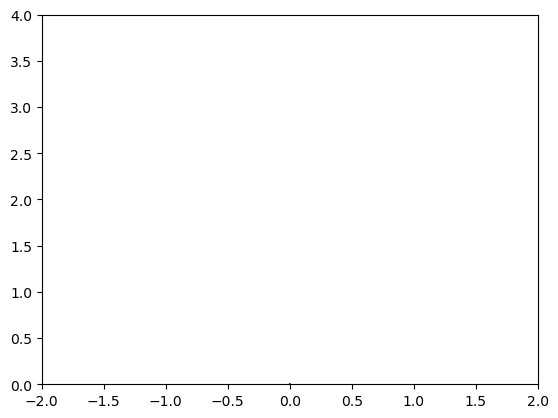

In [20]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes

def plot_pendulum(i,th1_in,th2_in,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2,2])
    ax.set_ylim([0,4])

    # Debug: Print current angles
    print(f"Frame {i}: th = {th1_in[i]}, alpha = {th2_in[i]}")
    
    #plot link 1
    L1topx = X0val
    L1topy = Y0val
    L1bottomx = X0val + l1val*np.sin(th1_in[i])
    L1bottomy = Y0val - l1val*np.cos(th1_in[i])
    ax.plot([L1topx,L1bottomx],[L1topy,L1bottomy],color='xkcd:black')
    
    #plot link 2
    L2bottomx = L1bottomx + l2val*np.sin(th1_in[i] + th2_in[i])
    L2bottomy = L1bottomy - l2val*np.cos(th1_in[i] + th2_in[i]) 
    ax.plot([L1bottomx,L2bottomx],[L1bottomy,L2bottomy],color='xkcd:black')
    
update = lambda i: plot_pendulum(i,th1ar,th2ar,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(N),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook